In [1]:
import pandas as pd
import numpy as np

import requests
from io import StringIO

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

# Problem C

## No missing values

In [2]:
url3 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat'
attributes = ('Latin hypercube study ID','simulation ID','climate model 1','climate model 2','climate model 3','climate model 4','climate model 5',
              'climate model 6','climate model 7','climate model 8','climate model 9','climate model 10','climate model 11',
              'climate model 12', 'climate model 13', 'climate model 14', 'climate model 15','climate model 16','climate model 17','climate model 18','simulation outcome'
  )
df3 = pd.read_csv(
    StringIO(requests.get(url3).content.decode('utf-8')), sep="\s+",names = attributes,header=0)

In [3]:
df3.isnull().sum()

Latin hypercube study ID    0
simulation ID               0
climate model 1             0
climate model 2             0
climate model 3             0
climate model 4             0
climate model 5             0
climate model 6             0
climate model 7             0
climate model 8             0
climate model 9             0
climate model 10            0
climate model 11            0
climate model 12            0
climate model 13            0
climate model 14            0
climate model 15            0
climate model 16            0
climate model 17            0
climate model 18            0
simulation outcome          0
dtype: int64

In [4]:
df3 = df3[~(df3 == '?').any(axis = 1)]
df3 = df3.sample(frac = 1, random_state = 7021).reset_index(drop = True)
df3 = df3.drop(columns = 'simulation ID')
df3[['Latin hypercube study ID','simulation outcome']] = df3[['Latin hypercube study ID','simulation outcome']].astype(str)

df3 = pd.get_dummies(df3, prefix=['Latin hypercube study ID', 'simulation outcome'])


## Split data

In [5]:
df3_final=df3.drop(columns = ['Latin hypercube study ID_1','simulation outcome_0'])
N_train3 = round(0.75 * df3_final.shape[0])
X = df3_final.iloc[:,:-1]
y = df3_final.iloc[:, -1]
X_train3 = X.iloc[0:N_train3,:]
X_test3 = X.iloc[N_train3:,:]
y_train3 = y.iloc[:N_train3]
y_test3 = y.iloc[N_train3:]
N3, P3 = X_train3.shape

In [6]:
attributes3=['climate model 1',
 'climate model 2',
 'climate model 3',
 'climate model 4',
 'climate model 5',
 'climate model 6',
 'climate model 7',
 'climate model 8',
 'climate model 9',
 'climate model 10',
 'climate model 11',
 'climate model 12',
 'climate model 13',
 'climate model 14',
 'climate model 15',
 'climate model 16',
 'climate model 17',
 'climate model 18',
'Latin hypercube study ID_2',
'Latin hypercube study ID_3',
             'simulation outcome_1']

## cross validation

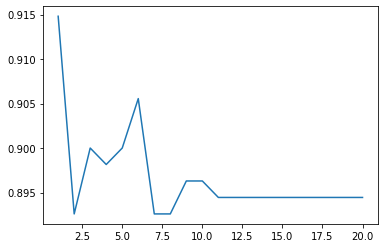

The highest score is 0.9148148148148149 and the corresponding depth is 1


In [8]:
%matplotlib inline 
from sklearn.model_selection import cross_val_score

score_list = []
depths = []

for dep in range(1,21):
    depths.append(dep)
    clf_cross = DecisionTreeClassifier(
        max_depth = dep, max_leaf_nodes = 2**dep, random_state = 7021)
    scores = cross_val_score(clf_cross, X, y, cv=5)
    score_list.append(scores.mean())

plt.plot(depths,score_list)
plt.show()

print('The highest score is', max(score_list), 'and the corresponding depth is', score_list.index(max(score_list))+1)

## CART

<IPython.core.display.Javascript object>


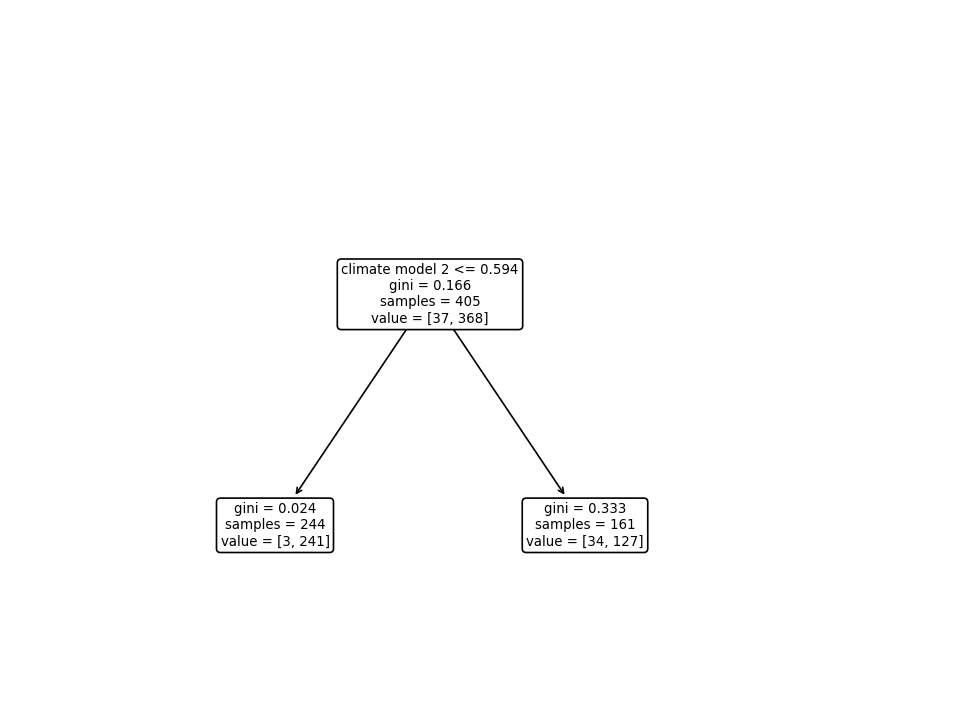

In [17]:
depth3 = 1
clf3 = DecisionTreeClassifier(
    max_depth = depth3, max_leaf_nodes = 2**depth3, random_state = 7021)
clf3.fit(X_train3, y_train3)
fig = plt.figure(figsize = (8, 6))
_ = plot_tree(
    clf3, filled = False, fontsize = 8, rounded = True, 
    feature_names = attributes3[0:-1])
fig.savefig('CART.png')

In [18]:
print(export_text(clf3, feature_names = attributes3[0:-1]))

|--- climate model 2 <= 0.59
|   |--- class: 1
|--- climate model 2 >  0.59
|   |--- class: 1



In [20]:
def find_path(root, path, x, children_left, children_right):
    path.append(root)
    if root == x:
        return True
    left = False
    right = False
    if (children_left[root] != -1):
        left = find_path(children_left[root], path, x, children_left, children_right)
    if (children_right[root] != -1):
        right = find_path(children_right[root], path, x, children_left, children_right)
    if left or right:
        return True
    path.remove(root)
    return False

def get_rule(path, children_left, attributes, feature, threshold):
    mask = ''
    for idx, node in enumerate(path):
        # filter out the leaf node
        if idx != len(path) - 1:
            # left or right branch node
            if (children_left[node] == path[idx + 1]):
                mask += "('{}' <= {:.2f}) \t ".format(
                    attributes[feature[node]], threshold[node])
            else:
                mask += "('{}' > {:.2f}) \t ".format(
                    attributes[feature[node]], threshold[node])
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "").strip()
    return mask

In [21]:
children_left3 = clf3.tree_.children_left
children_right3 = clf3.tree_.children_right
feature3 = clf3.tree_.feature
threshold3 = clf3.tree_.threshold

In [22]:
leaf_id3 = np.unique(clf3.apply(X_train3))
paths3 = {}
for leaf in leaf_id3:
    path_leaf3 = []
    find_path(0, path_leaf3, leaf, children_left3, children_right3)
    paths3[leaf] = path_leaf3

CART_rules3 = {}
for leaf in paths3:
    CART_rules3[leaf] = get_rule(paths3[leaf], children_left3, attributes3[0:-1], feature3, threshold3)

In [23]:
CART_rules3

{1: "('climate model 2' <= 0.59)", 2: "('climate model 2' > 0.59)"}

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

total_nodes3 = clf3.tree_.node_count
leaf_nodes3 = round(total_nodes3 / 2)
branch_nodes3 = total_nodes3 // 2

initial_a3 = np.array([i for i in clf3.tree_.feature if i != -2])
initial_b3 = np.array([i for i in clf3.tree_.threshold if i != -2])

In [25]:
clf3.score(X_train3, y_train3)
clf3.score(X_test3, y_test3)

0.908641975308642

0.9333333333333333

### Rules and performance of CART

In [27]:
print('The decision rules in CART is ', CART_rules3)
print('\nThe in-sample performance in CART is', clf3.score(X_train3, y_train3))
print('\nThe out-of-sample performance in CART is', clf3.score(X_test3, y_test3))

The decision rules in CART is  {1: "('climate model 2' <= 0.59)", 2: "('climate model 2' > 0.59)"}

The in-sample performance in CART is 0.908641975308642

The out-of-sample performance in CART is 0.9333333333333333


## OCT

Based on the structure of CART, the depth of OCT is also 1.

After respectively testing on alpha = 0.3, 0.5, 0.6 and epsilon = 0.01, 0.0001, 10e-7, 10e-8, 10e-9, 10e-10, I find that the best accuracy is based on alpha = 0.5 and epsilon = 0.01.

In [28]:
alpha3 = 0.5
K3 = 2
# Y Matrix
Y3 = np.zeros([N3, K3], dtype = int) - 1
Y3[X_train3.index, y_train3.astype(int)] = 1

In [29]:
# Decision Variables
import os
os.add_dll_directory(os.path.join(os.getenv('GUROBI_HOME'), 'bin'))

from gurobipy import *
model3 = Model('mip1')

# declare decision variables

# d: [# branch nodes], whether a branch node applies a split or not
d3 = model3.addVars(branch_nodes3 ,vtype = GRB.BINARY, name = "d") # ∈ {0, 1}
# split criterion: ax < b / ax >== b
# a: [# branch nodes, p], b: [# branch nodes]
a3 = model3.addVars(branch_nodes3, P3, vtype = GRB.BINARY, name = 'a') # ∈ {0, 1}
b3 = model3.addVars(branch_nodes3 ,vtype = GRB.CONTINUOUS, name = "b")

# l: [# leaf nodes], whether a leaf node contains any points or not
l3 = model3.addVars(leaf_nodes3, vtype = GRB.BINARY, name = "l") # ∈ {0, 1}
# z: [# points, # branch nodes], a point is assigned to which leaf node
z3 = model3.addVars(N3, leaf_nodes3, vtype = GRB.BINARY, name = "z") # ∈ {0, 1}

# N_kt: [# labels, # leaf nodes], number of points labelled for class k in a leaf node
N_kt3 = model3.addVars(K3, leaf_nodes3, vtype = GRB.INTEGER, name = "N_kt")
# N_t: [# leaf nodes], number of points in the leaf
N_t3 = model3.addVars(leaf_nodes3, vtype = GRB.INTEGER, name = "N_t")

# c_kt: [# labels, # leaf nodes], whether predicted label is label k for a leaf node
c_kt3 = model3.addVars(K3, leaf_nodes3, vtype = GRB.BINARY, name = "c") # ∈ {0, 1}
# L: [# leaf nodes], misclassification loss for a leaf node
L3 = model3.addVars(leaf_nodes3, vtype = GRB.INTEGER, name = "L")

<AddedDllDirectory('F:\\gurobi\\win64\\bin')>

Using license file C:\Users\Ke Xu\gurobi.lic
Academic license - for non-commercial use only - expires 2021-02-09


In [30]:
# Warm Start
# warm start using the results of CART algorithm
for t in range(branch_nodes3):
    a3[t, initial_a3[t]].start = 1
    b3[t].start = initial_b3[t]

model3.update()

In [35]:
# objective function
# baseline accuracy by predicting the dominant label for the whole dataset
L_hat3 = y_train3.value_counts().max()/y_train3.shape[0]
# declare the objective
model3.setObjective(L3.sum()/L_hat3 + alpha3 * d3.sum(), GRB.MINIMIZE)

In [37]:
# Constraints
def get_parent(i, depth = 1):
    assert i > 0, "No parent for Root"
    assert i <= 2 ** (depth + 1) - 1, "Error! Total: {0}; i: {1}".format(
        2 ** (depth + 1) - 1, i)
    return int((i - 1)/2)

# constraint set 1 
for t in range(branch_nodes3):
    model3.addConstr(a3.sum(t, '*') == d3[t]) # sum(a_tj for j in P) = d_t
    b3[t].setAttr(GRB.Attr.LB, 0) # b_t >= 0
    model3.addConstr(b3[t] <= d3[t]) # b_t <= d_t
    model3.addConstr(d3[t] == 1) # d_t = 1 (assume all the branch applies a split)

# constraint set 2
for t in range(1, branch_nodes3): # exception: root
    model3.addConstr(d3[t] <= d3[get_parent(t)]) # d_t <= d_p(t)
    
# constraint set 3
for i in range(N3):
    model3.addConstr(z3.sum(i, '*') == 1) # sum(z_it for t in T_L)

# constraint set 4
N_min3 = 1
for t in range(leaf_nodes3):
    model3.addConstr(l3[t] == 1) # l_t == 1 (assume leaf contains points)
    for i in range(N3):
        model3.addConstr(z3[i, t] <= l3[t]) # z_it <= l_t
    model3.addConstr(z3.sum('*', t) >= N_min3 * l3[t]) # sum(z_it for i in N) >= N_min * l_t

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

In [38]:
all_branch_nodes3 = list(reversed(range(branch_nodes3)))
depth_dict3 = {}
for i in range(depth3):
    depth_dict3[i] = sorted(all_branch_nodes3[-2**i:])
    for j in range(2**i):
        all_branch_nodes3.pop()
depth_dict3

0

{0: [0]}

In [39]:
all_leaf_nodes3 = list(range(leaf_nodes3))
branch_dict3 = {}
for i in range(branch_nodes3):
    for k in range(depth3):
        if i in depth_dict3[k]:
            floor_len3 = len(depth_dict3[k])
            step3 = 2**depth3 // floor_len3
            sliced_leaf3 = [all_leaf_nodes3[i:i+step3] for i in range(0, 2**depth3, step3)]
            idx3 = depth_dict3[k].index(i)
            branch_dict3[i] = sliced_leaf3[idx3]
        else:
            continue
branch_dict3

{0: [0, 1]}

In [40]:
epsilon = 0.01
# constraint set 5
for i in range(N3):
    for tl in range(leaf_nodes3):
        for tb in range(branch_nodes3):
            if tl in branch_dict3[tb]:
                length3 = len(branch_dict3[tb])
                idx3 = branch_dict3[tb].index(tl)
                # left-branch ancestors: 
                # np.dot(a_m.T, (x_i + mu))<= b_m + (1 + mu)(1- z_it)
                if idx3+1 <= length3//2:
                    model3.addConstr(
                        sum(a3.select(tb, '*') * X_train3.iloc[i, :]) + epsilon 
                        <= b3[tb] + (1 + epsilon) * (1 - z3[i, tl]))
                # right-branch ancestors: 
                # np.dot(a_m.T, x_i) >= b_m - (1- z_it)
                elif idx3+1 > length3//2:
                    model3.addConstr(
                        sum(a3.select(tb, '*') * X_train3.iloc[i, :]) 
                        >= b3[tb] - (1 - z3[i, tl]))
            else:
                continue

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

In [41]:
# constraint set 6, 7 & 8
for t in range(leaf_nodes3):
    
    # constraint set 8
    model3.addConstr(L3[t] >= 0) # L_t >= 0
    for k in range(K3):
        # L_t >= N_t - N_kt - n(1 - c_kt)
        model3.addConstr(L3[t] >= N_t3[t] - N_kt3[k, t] - N3 * (1 - c_kt3[k, t])) 
        # L_t <= N_t - N_kt + n * c_kt
        model3.addConstr(L3[t] <= N_t3[t] - N_kt3[k, t] + N3 * c_kt3[k, t]) 
        
        # constraint set 6
        # N_kt = 1/2 sum((1 + Y_ik)z_it for i in N)
        model3.addConstr(N_kt3[k, t] == 1/2 * sum(z3.select('*', t) * (Y3[:, k] + 1))) 
    
    model3.addConstr(N_t3[t] == z3.sum('*', t)) # N_t = sum(z_it for i in n)
    # constraint set 7
    model3.addConstr(c_kt3.sum('*', t) == l3[t]) # l_t = sum(c_kt for k in K)

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

<gurobi.Constr *Awaiting Model Update*>

In [42]:
model3.Params.timelimit = 60*5
model3.optimize()

Changed value of parameter timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3272 rows, 846 columns and 24934 nonzeros
Model fingerprint: 0xf5e3c76c
Variable types: 1 continuous, 845 integer (837 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]

User MIP start did not produce a new incumbent solution

Presolve removed 2450 rows and 413 columns
Presolve time: 0.02s
Presolved: 822 rows, 433 columns, 17194 nonzeros
Variable types: 1 continuous, 432 integer (427 binary)
Found heuristic solution: objective 41.2201087

Root relaxation: objective 5.000000e-01, 7 iterations, 0.00 seconds
Another try with MIP start

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dep

In [43]:
print('Obj:', model3.objVal)

Obj: 41.22010869565217


In [56]:
# Obtain the tree structure
coef_a3 = np.zeros([branch_nodes3, P3], dtype = int)
coef_b3 = np.zeros(branch_nodes3)

In [57]:
for i in range(branch_nodes3):
    b3 = model3.getVarByName('b' + '[' + str(i) + ']')
    coef_b3[i] = b3.x
    for j in range(P3):
        a3 = model3.getVarByName('a' + '[' + str(i) + ',' + str (j) + ']')
        coef_a3[i, j] = int(a3.x)

In [58]:
_ , a_idx = np.where(coef_a3 == 1)
a_idx = a_idx.tolist()

OCT_a3 = []
for i in range(len(feature3)):
    if i in np.where(feature3 == -2)[0]:
        OCT_a3.append(-2)
    else:
        OCT_a3.append(a_idx[0])
        a_idx.pop(0)

OCT_b3 = []
tmp_b3 = coef_b3.tolist()
for i in range(len(threshold3)):
    if i in np.where(threshold3 == -2)[0]:
        OCT_b3.append(-2)
    else:
        OCT_b3.append(round(tmp_b3[0], 2))
        tmp_b3.pop(0)

19

0.009999999999998233

In [59]:
OCT_rules3 = {}
for leaf in paths3:
    OCT_rules3[leaf] = get_rule(
        paths3[leaf], children_left3, attributes3[0:-1], OCT_a3, OCT_b3)

In [60]:
coef_c3 = np.zeros([K3, leaf_nodes3], dtype = int)

for i in range(K3):
    for j in range(leaf_nodes3):
        c3 = model3.getVarByName('c' + '[' + str(i) + ',' + str (j) + ']')
        coef_c3[i,j] = int(c3.x)

k_idx, t_idx = np.where(coef_c3 == 1)
labels3 = np.zeros(leaf_nodes3, dtype = int) - 1
for i in range(len(k_idx)):
    labels3[t_idx[i]] = k_idx[i]

In [61]:
y_hat3 = np.hstack([
    np.reshape(y_train3.values, (N3, 1)), 
    np.zeros([N3, 1], dtype = int)])
num_nodes3 = 0
for i in range(branch_nodes3): 
    d3 = model3.getVarByName('d' + '[' + str(i) + ']')
    num_nodes3 += int(d3.x)
num_nodes3
# initialize 
init3 = np.array([], dtype = int).reshape(0, P3)
nodes3 = {}
for i in range(num_nodes3 * 2):
    nodes3[i] = init3

# split
for i in range(N3):
    if np.dot(coef_a3[0,:], np.transpose(X_train3.iloc[i,:])) <= coef_b3[0]:
        nodes3[0] = np.vstack([X_train3.iloc[i,:], nodes3[0]])
        y_hat3[i,1] = labels3[0]

    elif np.dot(coef_a3[0,:], np.transpose(X_train3.iloc[i,:])) > coef_b3[0]:
        nodes3[1] = np.vstack([X_train3.iloc[i,:], nodes3[1]])
        y_hat3[i,1] = labels3[1]

1

In [62]:
performance_in = 1 - sum(np.abs(y_hat3[:,1] - y_hat3[:,0])) / N3

In [63]:
for i in range(len(labels3)):
    print('\nNode {}'.format(str(i+7)))
    print('Predicted label: {}'.format(str(labels3[i])))
    print('No. of obs.: {}'.format(nodes3[i].shape[0]))


Node 7
Predicted label: 1
No. of obs.: 273

Node 8
Predicted label: 1
No. of obs.: 132


In [64]:
N_prime3, P3 = X_test3.shape
y_predict3 = np.hstack([
    np.reshape(y_test3.values, (N_prime3, 1)), 
    np.zeros([N_prime3, 1], dtype = int)])

# initialize 
init3 = np.array([], dtype = int).reshape(0, P3)
nodes3 = {}
for i in range(num_nodes3 * 2):
    nodes3[i] = init3

for i in range(N_prime3):
    if np.dot(coef_a3[0,:], np.transpose(X_test3.iloc[i,:])) <= coef_b3[0]:
        nodes3[0] = np.vstack([X_test3.iloc[i,:], nodes3[0]])
        y_predict3[i,1] = labels3[0]
    elif np.dot(coef_a3[0,:], np.transpose(X_test3.iloc[i,:])) > coef_b3[0]:
        nodes3[1] = np.vstack([X_test3.iloc[i,:], nodes3[1]])
        y_predict3[i,1] = labels3[1]

In [65]:
performance_out = 1 - sum(np.abs(y_predict3[:,1] - y_predict3[:,0])) / N_prime3

In [66]:
for i in range(len(labels3)):
    print('\nNode {}'.format(str(i+7)))
    print('Predicted label: {}'.format(str(labels3[i])))
    print('No. of obs.: {}'.format(nodes3[i].shape[0]))


Node 7
Predicted label: 1
No. of obs.: 87

Node 8
Predicted label: 1
No. of obs.: 48


###  Rules and performance of OCT

In [67]:
print('The decision rules in OCT is ', OCT_rules3)
print('\nThe in-sample performance in OCT is', performance_in)
print('\nThe out-of-sample performance in OCT is',  performance_out)

The decision rules in OCT is  {1: "('Latin hypercube study ID_3' <= 0.01)", 2: "('Latin hypercube study ID_3' > 0.01)"}

The in-sample performance in OCT is 0.908641975308642

The out-of-sample performance in OCT is 0.9333333333333333


 **In this dataset, OCT and CART's performance is the same.**